In [7]:
import copy
import numpy as np
import pandas as pd
import qiime2 as q2
from biom import Table
from scipy.stats import ttest_ind
from qiime2.plugins.deicode.actions import rpca
#from qiime2.plugins.songbird.actions import multinomial
from qiime2.plugins.emperor.actions import biplot, plot
from skbio.stats.composition import alr

import os
import glob

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

### bin genes into pathways

In [332]:
indir_annot = 'data/funcational-annotations/bin_funct_annotations'
all_gff = {}
for bin_ in glob.glob(os.path.join(indir_annot,'*.gff')):
    bin_name = bin_.split('/')[-1].split('.g')[0]
    annot_ = pd.read_csv(bin_,sep='\t', header=None)
    info_ = pd.read_csv(os.path.join(indir_annot.replace('bin_funct_annotations','prokka_out_tsv'),
                             '%s.tsv'%(bin_name)), sep='\t')
    all_gff[bin_name] = pd.concat([annot_, info_], axis=1)

functional_mapping = pd.concat(all_gff).reset_index().drop('level_1', axis=1)
functional_mapping.columns = functional_mapping.columns.astype(str)
functional_mapping = functional_mapping.rename({'level_0':'bin_id','0':'contig','1':'source',
                               '2':'region','3':'start',
                               '4':'end','5':'score',
                               '6':'strand','7':'phase',
                               '8':'attributes'}, axis=1)
functional_mapping.to_csv('data/funcational-annotations/grouped-annotations.gff', sep='\t')
functional_mapping.head(5)


,bin_id,contig,source,region,start,end,score,strand,phase,attributes,locus_tag,ftype,length_bp,gene,EC_number,COG,product
0,bin.339,NODE_11723_length_8687,Prodigal:2.6,CDS,280,1383,.,+,0,ID=DCBJGPKD_00001;inference=ab initio predicti...,DCBJGPKD_00001,CDS,1104,NaN,NaN,NaN,hypothetical protein
1,bin.339,NODE_11723_length_8687,Prodigal:2.6,CDS,1416,2084,.,+,0,ID=DCBJGPKD_00002;inference=ab initio predicti...,DCBJGPKD_00002,CDS,669,NaN,NaN,NaN,hypothetical protein
2,bin.339,NODE_11723_length_8687,Prodigal:2.6,CDS,2139,3314,.,-,0,ID=DCBJGPKD_00003;eC_number=3.-.-.-;Name=yxeP_...,DCBJGPKD_00003,CDS,1176,yxeP_1,3.-.-.-,COG1473,putative hydrolase YxeP
3,bin.339,NODE_11723_length_8687,Prodigal:2.6,CDS,3314,4504,.,-,0,ID=DCBJGPKD_00004;eC_number=3.-.-.-;Name=yxeP_...,DCBJGPKD_00004,CDS,1191,yxeP_2,3.-.-.-,COG1473,putative hydrolase YxeP
4,bin.339,NODE_11723_length_8687,Prodigal:2.6,CDS,4594,6162,.,-,0,ID=DCBJGPKD_00005;Name=abgT_1;dbxref=COG:COG29...,DCBJGPKD_00005,CDS,1569,abgT_1,NaN,COG2978,p-aminobenzoyl-glutamate transport protein


In [1031]:
# import ModelSeed Classes
mdlseed_subsys = pd.read_csv('data/pathway-maps/ModelSEED_Subsystems.tsv', sep='\t')
# map to reaction info
reaction_map = pd.read_csv('data/pathway-maps/reactions.tsv', sep='\t', index_col=0)
for tmp_col in reaction_map.columns:
    tmp_dict = reaction_map[tmp_col].to_dict()
    mdlseed_subsys[tmp_col] = [tmp_dict[rxn_tmp] for rxn_tmp in mdlseed_subsys.Reaction]
# subset of EC numbers
mdlseed_subsys['EC'] = [x.split('EC')[1].split(')')[0].lstrip().rstrip().replace(':','').replace('[','').replace(']','')
                        if 'EC' in x else np.nan
                        for x in mdlseed_subsys.Role]
# merge lists by EC#
mdlseed_subsys_ecgrouped = mdlseed_subsys.groupby('EC').agg({col_:list for col_ in mdlseed_subsys.columns[:-1]}).drop(['F transporter',
                                                                                                                       'F transporter for HydroxyMethylPyrimidine'])
# add KEGG and MetaCyc pathways 
mdlseed_subsys_ecgrouped['MetaCyc'] = [[y.split('(')[-1].replace(')','').replace('<i>','').replace('N','').replace('</i>','').replace('<sup>','')
                                        for z in x if 'MetaCyc' in str(z) 
                                        for y in z.split('|')[0].split(';')] 
                                       for x in mdlseed_subsys_ecgrouped.pathways.values]
mdlseed_subsys_ecgrouped['KEGG'] = [[y.split('(')[-1].replace(')','').replace('<i>','').replace('N','').replace('</i>','').replace('<sup>','').replace('Carbon fixation pathways in prokaryotes','Carbon fixation')
                                     for z in x if 'KEGG' in str(z) 
                                     for y in z.split('KEGG')[1].split(';')] 
                                    for x in mdlseed_subsys_ecgrouped.pathways.values]


dont_use = ['1.1.1.1','1.2.1.10','2.7.2.1', '2.3.1.8','6.2.1.1']
mdlseed_subsys_ecgrouped = mdlseed_subsys_ecgrouped.drop(dont_use)

mdlseed_subsys_ecgrouped.head(4)


,Class,Sub-class,Name,Role,Reaction,abbreviation,name,code,stoichiometry,is_transport,...,deltag,deltagerr,compound_ids,status,is_obsolete,linked_reaction,notes,source,MetaCyc,KEGG
EC,,,,,,,,,,,,,,,,,,,,,
1.-.-.-,"[-, -, Carbohydrates, Cofactors, Vitamins, Pro...","[-, -, Central carbohydrate metabolism, Folate...","[Nitric_oxide_synthase, Nitric_oxide_synthase,...","[Nitric oxide synthase oxygenase (EC 1.-.-.-),...","[rxn00082, rxn00400, rxn00159, rxn00082, rxn00...","[(nitric-oxide-forming), R00558, R00214, (nitr...","[N-(omega)-Hydroxyarginine,NADPH:oxygen oxidor...",[(1) cpd00005[0] + (1) cpd00007[0] + (2) cpd03...,"[-1:cpd00005:0:0:""NADPH"";-1:cpd00007:0:0:""O2"";...","[0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[10000000.0, -59.15, 3.13, 10000000.0, -59.15,...","[10000000.0, 7.12, 0.76, 10000000.0, 7.12, 100...",[cpd00005;cpd00006;cpd00007;cpd00067;cpd00274;...,"[CI:4, OK, OK, CI:4, OK, CI:4, OK, OK, OK]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[nan, nan, rxn27459;rxn31389;rxn37872, nan, na...","[HB|GCP|EQP, GCC|HB|EQP, GCC|EQC|EQU, HB|GCP|E...","[Orphan, Primary Database, Primary Database, O...","[Amine and Polyamine Degradation, Sugar Biosyn...","[Arginine and proline metabolism, Pyruvate met..."
1.1.1.-,"[Carbohydrates, Carbohydrates, Carbohydrates, ...","[Fermentation, Fermentation, Fermentation, Fer...","[Acetone_Butanol_Ethanol_Synthesis, Acetone_Bu...",[NADH-dependent butanol dehydrogenase A (EC 1....,"[rxn02527, rxn02527, rxn02527, rxn02527, rxn02...","[R03544, R03544, R03544, R03544, R03234, R0086...","[R03544, R03544, R03544, R03544, R03234, D-Man...",[(1) cpd00004[0] + (1) cpd01011[0] <=> (1) cpd...,"[-1:cpd00004:0:0:""NADH"";-1:cpd00067:0:0:""H+"";-...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[-5.66, -5.66, -5.66, -5.66, -5.13, 2.56, 2.56...","[0.58, 0.58, 0.58, 0.58, 0.52, 0.44, 0.44, 0.5...","[cpd00003;cpd00004;cpd00067;cpd01011;cpd03662,...","[OK, OK, OK, OK, OK, OK, OK, OK, OK, OK]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[nan, nan, nan, nan, rxn37014, nan, nan, rxn37...","[GCC|EQC|EQU, GCC|EQC|EQU, GCC|EQC|EQU, GCC|EQ...","[Primary Database, Primary Database, Primary D...","[Fermentation to Alcohols, Generation of Precu...","[Butanoate metabolism, Butanoate metabolism, B..."
1.1.1.100,"[Cell Wall and Capsule, Cell Wall and Capsule,...","[Cell wall of Mycobacteria, Cell wall of Mycob...","[mycolic_acid_synthesis, mycolic_acid_synthesi...",[3-oxoacyl-[acyl-carrier protein] reductase (E...,"[rxn05336, rxn05337, rxn05338, rxn05339, rxn05...","[R04543, R04953, R04534, R04533, R04964, R0453...",[(3R)-3-Hydroxypalmitoyl-[acyl-carrier-protein...,[(1) cpd00006[0] + (1) cpd11481[0] <=> (1) cpd...,"[-1:cpd00006:0:0:""NADP"";-2:cpd00067:0:0:H+;-1:...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[10000000.0, 10000000.0, 10000000.0, 10000000....","[10000000.0, 10000000.0, 10000000.0, 10000000....","[cpd00005;cpd00006;cpd00067;cpd11481;cpd11485,...","[CI:-3, OK|CK|CI:-1, OK, CI:-2, OK|CK|CI:-1, O...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[rxn31257, rxn31269;rxn38483;rxn38484, rxn3125...","[HB|GCP|EQP, HB|GCP|EQP, GCP|EQP, HB|GCP|EQP, ...","[Primary Database, Primary Database, Primary D...","[Fatty Acid Biosynthesis, Fatty Acid and Lipid...","[Fatty acid biosynthesis, Fatty acid metabolis..."
1.1.1.103,"[Amino Acids and Derivatives, Amino Acids and ...","[Alanine, serine, and glycine, Lysine, threoni...","[Glycine_Biosynthesis, Threonine_degradation]","[L-threonine 3-dehydrogenase (EC 1.1.1.103), L...","[rxn01068, rxn01068]","[R01465, R01465]","[L-threonine:NAD+ oxidoreductase, L-threonine:...",[(1) cpd00003[0] + (1) cpd00161[0] <=> (1) cpd...,"[-1:cpd00003:0:0:""NAD"";-1:cpd00161:0:0:""L-Thre...","[0, 0]",...,"[6.62, 6.62]","[0.66, 0.66]","[cpd00003;cpd00004;cpd00067;cpd00161;cpd02211,...","[OK, OK]","[0, 0]","[rxn33041;rxn33043, rxn33041;rxn33043]","[GCC|EQC|EQU, GCC|EQC|EQU]","[Primary Database, Primary Database]","[Amino Acid Degradation, Aminopropanol Phospha...","[Glycine, serine and threonine metabolism, Gly...

In [1032]:
# merge all pathway data with GFF file for each annotated bin CDS
functional_mapping = functional_mapping.copy().dropna(subset=['EC_number'])
shared = set(functional_mapping['EC_number']) & set(mdlseed_subsys_ecgrouped.index)
functional_mapping = functional_mapping[functional_mapping.EC_number.isin(shared)]
mdlseed_subsys_ecgrouped = mdlseed_subsys_ecgrouped.reindex(shared)
for tmp_col in mdlseed_subsys_ecgrouped.columns:
    tmp_dict = mdlseed_subsys_ecgrouped[tmp_col].to_dict()
    functional_mapping[tmp_col] = [tmp_dict[ec_tmp] for ec_tmp in functional_mapping.EC_number]
functional_mapping.to_csv('data/funcational-annotations/grouped-annotations-pathways.gff', sep='\t')

functional_mapping.head(5)
    

,bin_id,contig,source,region,start,end,score,strand,phase,attributes,...,ec_numbers,deltag,deltagerr,compound_ids,status,is_obsolete,linked_reaction,notes,MetaCyc,KEGG
5,bin.339,NODE_11723_length_8687,"[Primary Database, Primary Database, Primary D...",CDS,6503,7813,.,-,0,ID=DCBJGPKD_00006;eC_number=3.5.1.-;Name=abgB_...,...,"[3.5.1.4, 3.5.1.-, 3.5.1.-]","[-2.84, -1.8, -1.8]","[0.54, 0.54, 0.54]","[cpd00001;cpd00013;cpd00703;cpd01747, cpd00001...","[OK, OK, OK]","[0, 0, 0]","[rxn30349;rxn38701;rxn38702, nan, nan]","[GCC|EQC|EQU, GCC|EQC|EQU, GCC|EQC|EQU]","[Auxin Biosynthesis, Hormone Biosynthesis, bac...",[Tryptophan metabolism]
8,bin.339,NODE_4477_length_19763,"[Primary Database, Primary Database, Primary D...",CDS,1064,2146,.,-,0,ID=DCBJGPKD_00009;eC_number=6.3.5.5;Name=carA;...,...,"[6.3.5.5, 6.3.5.5, 6.3.5.5, 6.3.5.5, 6.3.5.5, ...","[-1.42, -1.42, -1.42, -1.42, -1.42, -1.42]","[0.64, 0.64, 0.64, 0.64, 0.64, 0.64]",[cpd00001;cpd00002;cpd00008;cpd00009;cpd00023;...,"[OK, OK, OK, OK, OK, OK]","[0, 0, 0, 0, 0, 0]","[rxn27743;rxn30627;rxn31216;rxn38060, rxn27743...","[GCC|HB|EQC|EQU, GCC|HB|EQC|EQU, GCC|HB|EQC|EQ...",[superpathway of arginine and polyamine biosyn...,"[Pyrimidine metabolism, Alanine, aspartate and..."
11,bin.339,NODE_4477_length_19763,"[Primary Database, Primary Database, Primary D...",CDS,3476,5311,.,-,0,ID=DCBJGPKD_00012;eC_number=2.6.1.16;Name=glmS...,...,"[2.6.1.16, 2.6.1.16, 2.6.1.16, 2.6.1.16, 2.6.1...","[-3.99, -3.99, -3.99, -3.99, -3.99, -3.99]","[0.64, 0.64, 0.64, 0.64, 0.64, 0.64]","[cpd00023;cpd00053;cpd00072;cpd00288, cpd00023...","[OK, OK, OK, OK, OK, OK]","[0, 0, 0, 0, 0, 0]","[rxn32367;rxn32369;rxn32371, rxn32367;rxn32369...","[GCC|EQC|EQU, GCC|EQC|EQU, GCC|EQC|EQU, GCC|EQ...",[],"[Alanine, aspartate and glutamate metabolism, ..."
24,bin.339,NODE_36532_length_2842,"[Primary Database, Primary Database, Primary D...",CDS,1007,2011,.,+,0,ID=DCBJGPKD_00025;eC_number=5.3.1.23;Name=mtnA...,...,"[5.3.1.23, 5.3.1.23, 5.3.1.23]","[-2.56, -2.56, -2.56]","[0.59, 0.59, 0.59]","[cpd02574;cpd02791, cpd02574;cpd02791, cpd0257...","[OK, OK, OK]","[0, 0, 0]","[nan, nan, nan]","[GCC|EQC|EQU, GCC|EQC|EQU, GCC|EQC|EQU]","[Amino Acid Biosynthesis, Degradation/Utilizat...","[Cysteine and methionine metabolism, Cysteine ..."
28,bin.339,NODE_32244_length_3225,"[Orphan, Orphan, Orphan, Orphan, Orphan, Orpha...",CDS,585,1535,.,-,0,ID=DCBJGPKD_00029;eC_number=2.7.7.6;Name=rpoA;...,...,"[nan, nan, nan, nan, nan, nan, nan]","[10000000.0, 10000000.0, 10000000.0, 10000000....","[10000000.0, 10000000.0, 10000000.0, 10000000....","[cpd17043, cpd17043, cpd17043, cpd17043, cpd17...","[CPDFORMERROR, CPDFORMERROR, CPDFORMERROR, CPD...","[0, 0, 0, 0, 0, 0, 0]","[nan, nan, nan, nan, nan, nan, nan]","[GCP|EQP, GCP|EQP, GCP|EQP, GCP|EQP, GCP|EQP, ...",[],[]


# experiment 1 (only)

In [786]:
mf = pd.read_csv('data/mapping-files/mapping-etoh-ctrl.tsv',
                     sep='\t', index_col=0)
mf.index.name = '#SampleID'
mf.index = mf.index.astype(str)
mf.loc['673etoh', 'treatment'] = 'EtOH'
mf.loc['673ctrl', 'treatment'] = 'Ctrl'
q2mf = q2.Metadata(mf)
mf.head(5)

,treatment
#SampleID,
1596,EtOH
457,EtOH
767,EtOH
300,EtOH
682,EtOH


In [787]:
# set the type of pathway to use (options KEGG/MetaCyc/Sub-Class/Class)
pathway_use = 'KEGG'


### expression

In [245]:
# import global feature to gene ID mapping from Prokka on bins
gff_mapping = pd.concat([pd.DataFrame([[x.split(';')[0], x.split(';')[1:]] for x in pd.read_csv(bin_gff, sep='\t', header=None)[8].values])
                         for bin_gff in glob.glob('data/metaG_functional_count_tables/*.gff')])
gff_mapping[0] = [x.split('=')[1] for x in gff_mapping[0]]
gff_mapping = gff_mapping.set_index(0)
gff_mapping.index.name = 'feature_id'
gff_mapping.columns = ['feature_information']
gff_mapping = gff_mapping.feature_information.to_dict()


In [246]:
# import expression tables
gene_expression_count_tables = [pd.read_csv(count_bin, sep='\t', index_col=0, skiprows=1).drop(['Chr','Start','End','Strand'], axis=1)
                                for count_bin in glob.glob('data/metaT_functional_count_tables/*.txt')]
gene_expression_count_tables = pd.concat(gene_expression_count_tables)
gene_align_length = gene_expression_count_tables['Length'].values
gene_expression_count_tables = gene_expression_count_tables.drop(['Length'], axis=1)
gene_expression_count_tables_rpk = 10**2 * (gene_expression_count_tables.T / gene_align_length).T
gene_expression_count_tables_rpk = gene_expression_count_tables_rpk.groupby(gene_expression_count_tables_rpk.index).sum()
gene_expression_count_tables_rpk.columns = [x.split('/')[-1].split('.')[1].split('_')[0] for x in gene_expression_count_tables_rpk.columns]
gene_expression_count_tables_rpk = gene_expression_count_tables_rpk[gene_expression_count_tables_rpk.sum(1) > 0]
gene_expression_count_tables_rpk.head(3)


,1596,300,457,624,626,627,668,673ctrl,673etoh,682,686,701,703,704,767,813
Geneid,,,,,,,,,,,,,,,,
ABDHCFIN_00021,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21645,0.0
ABDHCFIN_00065,0.0,0.0,0.0,0.03647,0.218818,0.109409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
ABDHCFIN_00322,0.0,0.0,0.0,0.00000,0.000000,0.406504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


In [247]:
# subset EC numbers
gff_mapping_ec = {k:v[0].replace('eC_number=', '') for k, v in gff_mapping.items()
                  if any('eC_number' in v_i for v_i in v)}
all_ec = set(gene_expression_count_tables_rpk.index) & set(gff_mapping_ec.keys())
gene_expression_count_tables_rpk_ec = gene_expression_count_tables_rpk.reindex(all_ec)
gene_expression_count_tables_rpk_ec.index = [gff_mapping_ec[x] for x in gene_expression_count_tables_rpk_ec.index]
gene_expression_count_tables_rpk_ec = gene_expression_count_tables_rpk_ec.groupby(gene_expression_count_tables_rpk_ec.index).sum()
gene_expression_count_tables_rpk_ec.head(5)


,1596,300,457,624,626,627,668,673ctrl,673etoh,682,686,701,703,704,767,813
1.-.-.-,0.306164,2.302647,6.635273,47.967920,176.112791,25.056512,0.361366,5.943539,81.327391,5.015448,6.747092,46.947713,0.267033,1.675482,0.054735,56.317409
1.1.-.-,0.000000,0.000000,0.000000,0.000000,0.097466,0.194932,0.000000,0.097466,0.000000,0.000000,0.000000,0.083963,0.000000,0.000000,0.000000,0.000000
1.1.1.-,0.088889,1.866887,8.402162,8.718599,31.230419,11.761358,1.031944,3.115454,45.514967,4.118187,6.403518,28.420318,0.462038,0.862514,0.087489,28.409425
1.1.1.1,0.000000,0.000000,0.385356,1.252969,0.781350,2.684644,0.096339,0.000000,6.298800,0.222222,0.915106,3.345523,0.000000,0.000000,0.000000,4.269875
1.1.1.100,0.126263,1.625796,3.592568,3.287732,12.883877,9.399746,0.133869,1.605716,32.394936,0.950303,1.157978,16.868819,0.133333,0.673729,0.000000,20.372972


In [1033]:
# pathways to gene maps
functional_mapping_pathway = functional_mapping.dropna(subset=[pathway_use])
functional_mapping_pathway.loc[:,'gene_id'] = [x.split(';')[0].replace('ID=','')
                                         for x in functional_mapping_pathway['attributes']]
functional_mapping_pathway = functional_mapping_pathway.set_index('gene_id')
functional_mapping_pathway = functional_mapping_pathway.reindex(set(gene_expression_count_tables_rpk.index) \
                                                                & set(functional_mapping_pathway.index))
functional_mapping_pathway_map = functional_mapping_pathway[pathway_use].to_dict()
functional_mapping_pathway_map_geneid = {}
for geneid, pathways in functional_mapping_pathway_map.items():
    for pathway in pathways:
        functional_mapping_pathway_map_geneid.setdefault(pathway, []).append(geneid)
# build table
pathway_expression_count_tables_rpk = gene_expression_count_tables_rpk.copy()
pathway_expression_count_tables_rpk = pathway_expression_count_tables_rpk.reindex(set(pathway_expression_count_tables_rpk.index) \
                                                                                  & set(functional_mapping_pathway.index))
pathway_expression_count_tables_rpk = pd.DataFrame({pathway:pathway_expression_count_tables_rpk.loc[geneids, :].sum(0)
                                                    for pathway, geneids in functional_mapping_pathway_map_geneid.items()}).T
pathway_expression_count_tables_rpk.index = [x
                                            for x in pathway_expression_count_tables_rpk.index]
pathway_expression_count_tables_rpk = pathway_expression_count_tables_rpk.groupby(pathway_expression_count_tables_rpk.index).sum()
pathway_expression_count_tables_rpk.loc['2.7.7.6', pathway_expression_count_tables_rpk.columns] = gene_expression_count_tables_rpk_ec.loc['2.7.7.6', pathway_expression_count_tables_rpk.columns].values
pathway_expression_count_tables_rpk.to_csv('data/metaT_functional_count_tables/rpk-pathway-expression.tsv', sep='\t')
pathway_expression_count_tables_rpk.head(5)

        

,1596,300,457,624,626,627,668,673ctrl,673etoh,682,686,701,703,704,767,813
2-Oxocarboxylic acid metabolism,5.618561,41.735133,150.314089,353.643081,1870.399751,382.347235,4.722106,144.127799,1369.661308,42.824544,23.940434,845.056220,36.115167,40.353721,3.824224,983.318214
"Alanine, aspartate and glutamate metabolism",13.893181,42.048267,99.131391,467.501026,1364.838940,452.259546,17.302719,208.764972,1470.318407,54.286059,84.168470,896.936990,17.971096,26.913702,0.449438,994.572383
Amino sugar and nucleotide sugar metabolism,17.530264,63.751461,221.209768,1123.126656,7010.917024,586.718482,72.436560,448.079586,1078.614655,82.379334,79.550277,672.233705,44.711355,98.184483,0.087489,853.367425
Aminoacyl-tRA biosynthesis,0.000000,1.080574,5.036383,15.979769,44.762910,22.461403,0.543709,5.654552,52.001924,5.346609,3.288955,27.219950,0.000000,1.366191,0.000000,27.349380
Aminobenzoate degradation,0.000000,1.319226,0.378743,1.754310,0.465205,14.237595,0.000000,0.830862,55.167071,0.282486,0.423729,32.170713,0.143988,0.000000,0.000000,40.269984


In [1034]:
# apply ALR transformation in RPK data with rpoB as the normalization feature
pathway_expression_count_tables_rpk_alr = pathway_expression_count_tables_rpk.copy().T + 1
gene_ids = list(pathway_expression_count_tables_rpk_alr.columns)
rpo_idx = gene_ids.index('2.7.7.6')
gene_ids.remove('2.7.7.6')
alr_vals = alr(pathway_expression_count_tables_rpk_alr.values, denominator_idx=rpo_idx)
alr_vals[~np.isfinite(alr_vals)] = np.nan
pathway_expression_count_tables_rpk_alr = pd.DataFrame(alr_vals,
                                                      pathway_expression_count_tables_rpk_alr.index,
                                                      gene_ids)
pathway_expression_count_tables_rpk_alr.to_csv('data/metaT_functional_count_tables/alr-pathway-expression.tsv', sep='\t')

pathway_expression_count_tables_rpk_alr.head(5)


,2-Oxocarboxylic acid metabolism,"Alanine, aspartate and glutamate metabolism",Amino sugar and nucleotide sugar metabolism,Aminoacyl-tRA biosynthesis,Aminobenzoate degradation,Arginine and proline metabolism,Ascorbate and aldarate metabolism,Atrazine degradation,Benzoate degradation,Benzoxazinoid biosynthesis,...,Ubiquinone and other terpenoid-quinone biosynthesis,"Valine, leucine and isoleucine biosynthesis","Valine, leucine and isoleucine degradation",Vitamin B6 metabolism,Xylene degradation,aphthalene degradation,beta-Alanine metabolism,icotinate and nicotinamide metabolism,itrogen metabolism,ovobiocin biosynthesis
1596,0.817300,1.628325,1.846827,-1.072578,-1.072578,1.397645,0.223051,0.219478,1.320714,-0.221332,...,0.041854,-0.142005,1.383872,1.173974,-0.442801,-1.072578,-0.584304,0.363121,0.558743,-0.071862
300,1.852877,1.860178,2.268412,-1.169500,-1.060911,2.032040,-0.245790,-1.244224,0.540443,-0.774865,...,-0.315665,1.599804,1.793473,1.738409,-1.213396,-1.902144,-0.813334,1.142598,1.478140,-0.738007
457,2.150798,1.737924,2.535062,-1.070755,-2.547387,1.877105,-0.474492,-2.868560,1.275409,-1.755944,...,-0.626285,1.760267,1.949789,1.750842,0.032320,-2.542280,-2.658365,1.246535,1.248642,-1.147186
624,1.404252,1.682678,2.557902,-1.634837,-3.453693,1.762843,-1.409239,-2.662790,1.922521,-1.153575,...,-0.766243,1.052386,1.840282,2.316626,-0.144585,-3.694410,-2.558572,0.416067,1.296056,-0.959942
626,2.026431,1.711513,3.347355,-1.684537,-5.126016,1.894043,-1.269706,-1.634054,2.520982,-0.438526,...,-0.669936,1.817592,2.560337,3.027892,-0.020125,-4.493950,-2.754002,0.992622,1.374088,-0.867319


### abundance

In [250]:
# import abundance tables
gene_abundance_count_tables = [pd.read_csv(count_bin, sep='\t', index_col=0, skiprows=1).drop(['Chr','Start','End','Strand'], axis=1)
                               for count_bin in glob.glob('data/metaG_functional_count_tables/*.txt')]
gene_abundance_count_tables = pd.concat(gene_abundance_count_tables)
gene_align_length = gene_abundance_count_tables['Length'].values
gene_abundance_count_tables = gene_abundance_count_tables.drop(['Length'], axis=1)
gene_abundance_count_tables_rpk = 10**2 * (gene_abundance_count_tables.T / gene_align_length).T
gene_abundance_count_tables_rpk = gene_abundance_count_tables_rpk.groupby(gene_abundance_count_tables_rpk.index).sum()
gene_abundance_count_tables_rpk.columns = [x.split('/')[-1].split('_')[1] for x in gene_abundance_count_tables_rpk.columns]
gene_abundance_count_tables_rpk = gene_abundance_count_tables_rpk[gene_abundance_count_tables_rpk.sum(1) > 0]
gene_abundance_count_tables_rpk.head(3)


,1596,300,457,5499,5500,5501,5502,5503,5504,5505,...,668,673ctrl,673etoh,682,686,701,703,704,767,813
Geneid,,,,,,,,,,,,,,,,,,,,,
ABDHCFIN_00001,0.0,0.0,0.000000,0.0,0.000000,0.0,0.179211,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
ABDHCFIN_00002,0.0,0.0,0.000000,0.0,0.108578,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.108578,0.0,0.000000,0.0
ABDHCFIN_00003,0.0,0.0,0.497512,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.248756,0.0


In [251]:
# subset EC numbers
gff_mapping_ec = {k:v[0].replace('eC_number=', '') for k, v in gff_mapping.items() if any('eC_number' in v_i for v_i in v)}
all_ec = set(gene_abundance_count_tables_rpk.index) & set(gff_mapping_ec.keys())
gene_abundance_count_tables_rpk_ec = gene_abundance_count_tables_rpk.reindex(all_ec)
gene_abundance_count_tables_rpk_ec.index = [gff_mapping_ec[x] for x in gene_abundance_count_tables_rpk_ec.index]
gene_abundance_count_tables_rpk_ec = gene_abundance_count_tables_rpk_ec.groupby(gene_abundance_count_tables_rpk_ec.index).sum()
gene_abundance_count_tables_rpk_ec.head(5)


,1596,300,457,5499,5500,5501,5502,5503,5504,5505,...,668,673ctrl,673etoh,682,686,701,703,704,767,813
1.-.-.-,807.905390,1091.500715,867.906468,33.106840,35.949604,49.412056,56.542547,10.911235,27.663860,61.410286,...,241.039854,653.934646,379.983694,1067.582457,617.354266,467.395672,519.111153,564.432418,880.421556,596.106494
1.1.-.-,5.938439,1.838102,4.616114,0.744986,0.363430,0.867790,0.690335,0.098619,0.295858,1.479290,...,1.179972,4.499085,0.000000,8.144416,3.190596,0.000000,3.030423,2.709848,10.121548,0.000000
1.1.1.-,355.003785,599.037990,618.679343,16.194010,17.096739,19.395513,29.046062,6.712746,15.481293,30.551408,...,154.858946,413.135714,186.263645,543.105634,359.121161,223.113864,299.757193,322.108674,763.017561,276.351718
1.1.1.1,109.782868,96.074673,62.390337,1.177958,1.619695,3.150663,1.833398,0.554067,1.162290,4.359699,...,22.784149,71.281987,32.215897,124.667388,79.233467,38.492947,26.527598,35.234220,49.324946,59.778083
1.1.1.100,227.569158,286.371976,312.105240,9.509329,10.397975,12.034324,23.099538,4.360709,8.132165,23.515533,...,49.173261,235.229465,97.740792,267.713156,165.970078,124.088913,164.014091,166.271083,369.023845,155.900711


In [916]:
# apply ALR transformation in RPK data with rpoB as the normalization feature
gene_expression_count_tables_rpk_ec_alr = gene_expression_count_tables_rpk_ec.copy().T + 0.7
gene_ids = list(gene_expression_count_tables_rpk_ec_alr.columns)
rpo_idx = gene_ids.index('2.7.7.6')
gene_ids.remove('2.7.7.6')
alr_vals = alr(gene_expression_count_tables_rpk_ec_alr.values, denominator_idx=rpo_idx)
alr_vals[~np.isfinite(alr_vals)] = np.nan
gene_expression_count_tables_rpk_ec_alr = pd.DataFrame(alr_vals,
                                                      gene_expression_count_tables_rpk_ec_alr.index,
                                                      gene_ids)
gene_expression_count_tables_rpk_ec_alr.head(5)


,1.-.-.-,1.1.-.-,1.1.1.-,1.1.1.1,1.1.1.100,1.1.1.103,1.1.1.108,1.1.1.119,1.1.1.122,1.1.1.127,...,6.4.-.-,6.4.1.2,6.4.1.3,6.4.1.7,6.4.1.8,6.5.1.-,6.5.1.2,6.5.1.4,6.6.1.1,6.6.1.2
1596,-0.958138,-1.320958,-1.201413,-1.320958,-1.155126,-1.320958,-1.320958,-1.320958,-1.320958,-1.320958,...,-1.320958,-1.157970,-0.937651,-1.241126,-1.320958,-1.320958,-0.964789,-1.320958,-1.320958,-1.320958
300,-0.756842,-2.213012,-0.913643,-2.213012,-1.012274,-2.213012,-1.951762,-2.213012,-2.213012,-2.213012,...,-2.213012,-2.131540,-1.608302,-1.869951,-2.213012,-2.103385,-2.019556,-2.213012,-2.213012,-2.213012
457,-0.858684,-3.208054,-0.642867,-2.769470,-1.394494,-3.208054,-3.208054,-3.023539,-3.208054,-2.765529,...,-3.208054,-3.208054,-2.531394,-2.952124,-3.208054,-3.098427,-2.541525,-3.208054,-3.208054,-3.208054
624,-0.578389,-4.820084,-2.220723,-3.794058,-3.080186,-4.233238,-4.680952,-4.820084,-4.820084,-4.648873,...,-4.686051,-3.321719,-2.275160,-3.944404,-4.694543,-3.962953,-3.293391,-4.820084,-4.820084,-4.620997
626,-0.331703,-5.733110,-2.043235,-5.113840,-2.897911,-4.226214,-4.480801,-5.863469,-5.863469,-4.439658,...,-5.772148,-3.327518,-2.478462,-4.090362,-5.370203,-3.957322,-3.425576,-5.863469,-5.863469,-5.606210


In [1035]:
# pathways to gene maps
functional_mapping_pathway = functional_mapping.dropna(subset=[pathway_use])
functional_mapping_pathway.loc[:,'gene_id'] = [x.split(';')[0].replace('ID=','')
                                         for x in functional_mapping_pathway['attributes']]
functional_mapping_pathway = functional_mapping_pathway.set_index('gene_id')
functional_mapping_pathway = functional_mapping_pathway.reindex(set(gene_abundance_count_tables_rpk.index) \
                                                                & set(functional_mapping_pathway.index))
functional_mapping_pathway_map = functional_mapping_pathway[pathway_use].to_dict()
functional_mapping_pathway_map_geneid = {}
for geneid, pathways in functional_mapping_pathway_map.items():
    for pathway in pathways:
        functional_mapping_pathway_map_geneid.setdefault(pathway, []).append(geneid)
# build table
pathway_abundance_count_tables_rpk = gene_abundance_count_tables_rpk.copy()
pathway_abundance_count_tables_rpk = pathway_abundance_count_tables_rpk.reindex(set(pathway_abundance_count_tables_rpk.index) \
                                                                                  & set(functional_mapping_pathway.index))
pathway_abundance_count_tables_rpk = pd.DataFrame({pathway:pathway_abundance_count_tables_rpk.loc[geneids, :].sum(0)
                                                    for pathway, geneids in functional_mapping_pathway_map_geneid.items()}).T
pathway_abundance_count_tables_rpk.index = [x
                                            for x in pathway_abundance_count_tables_rpk.index]
pathway_abundance_count_tables_rpk = pathway_abundance_count_tables_rpk.groupby(pathway_abundance_count_tables_rpk.index).sum()
pathway_abundance_count_tables_rpk.loc['2.7.7.6', pathway_abundance_count_tables_rpk.columns] = gene_abundance_count_tables_rpk_ec.loc['2.7.7.6', pathway_abundance_count_tables_rpk.columns].values
pathway_abundance_count_tables_rpk.to_csv('data/metaG_functional_count_tables/rpk-pathway-abundance.tsv', sep='\t')
pathway_abundance_count_tables_rpk.head(5)



,1596,300,457,5499,5500,5501,5502,5503,5504,5505,...,668,673ctrl,673etoh,682,686,701,703,704,767,813
2-Oxocarboxylic acid metabolism,18764.777840,17115.282967,11829.569974,473.257112,571.716549,605.176018,1009.286401,146.249920,393.447161,1007.209706,...,5508.988053,14061.411330,6435.902339,15461.894044,10381.833804,8199.436831,12886.563408,12980.061089,13252.502956,10001.529216
"Alanine, aspartate and glutamate metabolism",21970.052289,22458.733724,18481.057470,750.706724,941.982998,925.474343,1790.011536,300.816416,795.489829,1782.230366,...,9036.566172,19026.967057,7228.120080,16205.605371,10543.596840,9348.420467,12720.721807,13429.770621,21899.352611,9806.293825
Amino sugar and nucleotide sugar metabolism,10573.166624,13825.657324,10850.945206,403.722500,564.101668,486.625573,941.180836,158.552588,418.250535,966.509309,...,4175.948788,10776.734017,4774.643693,10318.856444,6173.583485,5549.705838,7663.263264,8301.565386,13076.919088,7094.263957
Aminoacyl-tRA biosynthesis,934.640194,819.513714,406.768235,12.350202,18.353156,22.059082,32.499784,4.004683,20.199830,30.833919,...,320.643019,627.957495,210.308922,620.898413,467.369835,297.810020,629.063654,656.496505,530.734584,305.665273
Aminobenzoate degradation,514.954301,414.275672,141.666560,7.835444,10.663191,18.340840,19.993088,2.666667,9.641824,15.224237,...,75.050008,306.410421,186.965123,259.226014,162.880366,256.712352,85.336003,139.093005,130.133144,464.168075


In [1036]:
# apply ALR transformation in RPK data with rpoB as the normalization feature
pathway_abundance_count_tables_rpk_alr = pathway_abundance_count_tables_rpk.copy().T + 1
gene_ids = list(pathway_abundance_count_tables_rpk_alr.columns)
rpo_idx = gene_ids.index('2.7.7.6')
gene_ids.remove('2.7.7.6')
alr_vals = alr(pathway_abundance_count_tables_rpk_alr.values, denominator_idx=rpo_idx)
alr_vals[~np.isfinite(alr_vals)] = np.nan
pathway_abundance_count_tables_rpk_alr = pd.DataFrame(alr_vals,
                                                      pathway_abundance_count_tables_rpk_alr.index,
                                                      gene_ids)
pathway_abundance_count_tables_rpk_alr.to_csv('data/metaG_functional_count_tables/alr-pathway-abundance.tsv', sep='\t')

pathway_abundance_count_tables_rpk_alr.head(5)


,2-Oxocarboxylic acid metabolism,"Alanine, aspartate and glutamate metabolism",Amino sugar and nucleotide sugar metabolism,Aminoacyl-tRA biosynthesis,Aminobenzoate degradation,Arginine and proline metabolism,Ascorbate and aldarate metabolism,Atrazine degradation,Benzoate degradation,Benzoxazinoid biosynthesis,...,Ubiquinone and other terpenoid-quinone biosynthesis,"Valine, leucine and isoleucine biosynthesis","Valine, leucine and isoleucine degradation",Vitamin B6 metabolism,Xylene degradation,aphthalene degradation,beta-Alanine metabolism,icotinate and nicotinamide metabolism,itrogen metabolism,ovobiocin biosynthesis
1596,3.708667,3.866358,3.135046,0.710108,0.114895,3.817463,1.167695,1.314699,1.320937,0.941527,...,2.542663,3.111952,3.136353,1.854685,0.907467,-2.441734,-0.054243,3.019700,3.232813,1.899062
300,3.584232,3.855926,3.370800,0.546377,-0.134611,3.854628,1.042711,0.492612,1.426948,0.927753,...,2.161365,2.981085,3.354536,1.808648,0.971361,-3.475008,-0.071085,2.880065,3.361362,1.723668
457,3.303483,3.749597,3.217141,-0.064260,-1.114449,3.853463,0.653985,-0.793134,1.415178,0.540634,...,1.537776,2.718597,3.115385,1.803657,0.893858,-1.813789,-0.126061,2.589436,3.325687,1.203827
5499,3.190772,3.651368,3.032224,-0.379446,-0.792206,3.598796,0.930765,1.453919,1.165677,0.178152,...,2.049386,2.570808,2.995139,1.284178,0.549411,-1.428891,-0.148207,2.456841,3.096487,1.208774
5500,3.301694,3.800351,3.288308,-0.085842,-0.592260,3.683259,1.169436,1.444063,1.492914,0.272914,...,2.023292,2.751244,3.099145,1.554139,0.625350,-2.440599,-0.230718,2.736976,3.227154,1.271460


### plot

In [850]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import minmax_scale

def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    sc = ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    num_ = 7
    
    labels = [int(v[14:][:-2])/size_scale
             for v in sc.legend_elements("sizes", num=num_)[1]]
    labels = np.around(minmax_scale(labels, (size_min, size_max)), 2)

    labels =  [str(l) for l in labels]
    handles = sc.legend_elements("sizes", num=num_)[0]
    legend_ = ax.legend(handles[:],labels[:],
                prop={'size':23}, loc=2, 
                handletextpad=0.1,
                bbox_to_anchor=(-0.25, 1.2),
                fancybox=True, framealpha=0.1,ncol=3
                , facecolor="white",
                edgecolor='black')
    
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45,
                       horizontalalignment='right',
                       color='black')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num],
                       color='black')

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax2 = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax2.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax2.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax2.grid(False) # Hide grid
        ax2.set_facecolor('white') # Make background white
        ax2.set_xticks([]) # Remove horizontal ticks
        ax2.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax2.yaxis.tick_right() # Show vertical ticks on the right 

    return ax
        

def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )


In [1037]:
shared_path = set(pathway_expression_count_tables_rpk_alr.columns) & set(pathway_expression_count_tables_rpk_alr.columns)
shared_samp = set(pathway_expression_count_tables_rpk_alr.index) & set(pathway_expression_count_tables_rpk_alr.index)

binned_heatmap = pd.concat([pathway_expression_count_tables_rpk_alr.loc[shared_samp, shared_path].stack().reset_index(),
                            pathway_abundance_count_tables_rpk_alr.loc[shared_samp, shared_path].stack().reset_index()[[0]]], axis=1)
binned_heatmap.columns = ['Sample', 'Pathway', 'Expression', 'Abundance']
binned_heatmap.head(3)


,Sample,Pathway,Expression,Abundance
0,704,Fatty acid biosynthesis,2.017456,3.478006
1,704,Aminoacyl-tRA biosynthesis,-0.783358,0.549746
2,704,Terpenoid backbone biosynthesis,1.589731,2.665717


In [1038]:
compound_use = 'cpd00022'

# pathway to reactions
map_rxns = pd.DataFrame([[path_tmp, rxn] for path_tmps, rxns in zip(mdlseed_subsys_ecgrouped[pathway_use],
                                                                    mdlseed_subsys_ecgrouped['Reaction'])
                         for path_tmp, rxn in zip(path_tmps, rxns)])
map_rxns = map_rxns.groupby(0).agg({1:set})[1].to_dict()
# check if any include compound_use include 
mdlseed_subsys[compound_use] = [compound_use in compound_tmp
                                for compound_tmp in mdlseed_subsys.compound_ids]
includes_compound = set(mdlseed_subsys[mdlseed_subsys[compound_use] == True].Reaction)
# check pathway
pathway_with_compound = [path for path, rxns in map_rxns.items() 
                         if any(rxn in rxns for rxn in includes_compound)][::-1]
pathway_with_compound.remove('aphthalene degradation')

binned_heatmap_plot = binned_heatmap[binned_heatmap.Pathway.isin(pathway_with_compound)]

binned_heatmap_plot.head(5)


,Sample,Pathway,Expression,Abundance
0,704,Fatty acid biosynthesis,2.017456,3.478006
2,704,Terpenoid backbone biosynthesis,1.589731,2.665717
8,704,Fatty acid elongation,0.671264,0.466637
11,704,Glycolysis / Gluconeogenesis,3.430457,3.543492
13,704,Lysine biosynthesis,0.228575,2.098488


In [1039]:
# map the direction of each pathway in consuming, producing, or bi-directional use of compound
direction = ['<','>']
direction_map = {True:'produced',False:'consumed'}
mdlseed_subsys_subcompound = mdlseed_subsys[mdlseed_subsys[compound_use] == True]
mdlseed_subsys_subcompound.loc[:, 'compound_reaction_direction'] = ['bi-directional' if '=' == y else direction_map[compound_use in x.split('<=>')[direction.index(y)]]
                                                                    for x, y in zip(mdlseed_subsys_subcompound.code, mdlseed_subsys_subcompound.direction)]
map_rxns_direction_compound = mdlseed_subsys_subcompound.groupby('Reaction').agg({'compound_reaction_direction':set})['compound_reaction_direction'].to_dict()
map_pathway_direction_compound = {pathway_:set([list(map_rxns_direction_compound[rxn])[0]
                                                for rxn in rxns if rxn in map_rxns_direction_compound.keys()])
                                  for pathway_, rxns in map_rxns.items()}
map_pathway_direction_compound['Fatty acid degradation'] = ['produced']
map_pathway_direction_compound['Fatty acid elongation'] = ['produced']

binned_heatmap_plot['compound_direction'] = [list(map_pathway_direction_compound[pathway_tmp])[0]
                                             if len(map_pathway_direction_compound[pathway_tmp]) != 0 else 'unknown'
                                             for pathway_tmp in binned_heatmap_plot.Pathway]

binned_heatmap_plot.head(5)



/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWith

,Sample,Pathway,Expression,Abundance,compound_direction
0,704,Fatty acid biosynthesis,2.017456,3.478006,bi-directional
2,704,Terpenoid backbone biosynthesis,1.589731,2.665717,consumed
8,704,Fatty acid elongation,0.671264,0.466637,produced
11,704,Glycolysis / Gluconeogenesis,3.430457,3.543492,bi-directional
13,704,Lysine biosynthesis,0.228575,2.098488,produced


In [1056]:
order_groups = {'Valine, leucine and isoleucine degradation':'Amino Acids',
                 'Valine, leucine and isoleucine biosynthesis':'Amino Acids',
                 'Tryptophan metabolism':'Amino Acids',
                 'Terpenoid backbone biosynthesis':'Aromatics',
                 'TCA cycle':'Respiration',
                 'Synthesis and degradation of ketone bodies':'Fatty Acids',
                 'Sulfur metabolism':'Respiration',
                 'Pyruvate metabolism':'Respiration',
                 'Propanoate metabolism':'Fatty Acids',
                 'Lysine degradation':'Amino Acids',
                 'Lysine biosynthesis':'Amino Acids',
                 'Glyoxylate and dicarboxylate metabolism':'Respiration',
                 'Glycolysis / Gluconeogenesis':'Respiration',
                 'Glycine, serine and threonine metabolism':'Amino Acids',
                 'Fatty acid metabolism':'Fatty Acids',
                 'Fatty acid elongation':'Fatty Acids',
                 'Fatty acid degradation':'Fatty Acids',
                 'Fatty acid biosynthesis':'Fatty Acids',
                 'Degradation of aromatic compounds':'Aromatics',
                 'Cysteine and methionine metabolism':'Amino Acids',
                 'Carbon metabolism':'Respiration',
                 'Carbon fixation':'Respiration',
                 'Butanoate metabolism':'Fatty Acids',
                 'Biosynthesis of secondary metabolites':'Secondary metabolite',
                 'Biosynthesis of amino acids':'Amino Acids',
                 'Benzoate degradation':'Aromatics',
                 'Arginine and proline metabolism':'Amino Acids',
                 'Amino sugar and nucleotide sugar metabolism':'Amino Acids'}
reversed_order_groups = {}
for key, value in order_groups.items():
    reversed_order_groups.setdefault(value, [])
    reversed_order_groups[value].append(key)
order_groups_keys = ['Respiration','Fatty Acids', 'Amino Acids','Aromatics','Secondary metabolite']
pathway_with_compound = [v_ for k_ in order_groups_keys for v_ in sorted(reversed_order_groups[k_])]


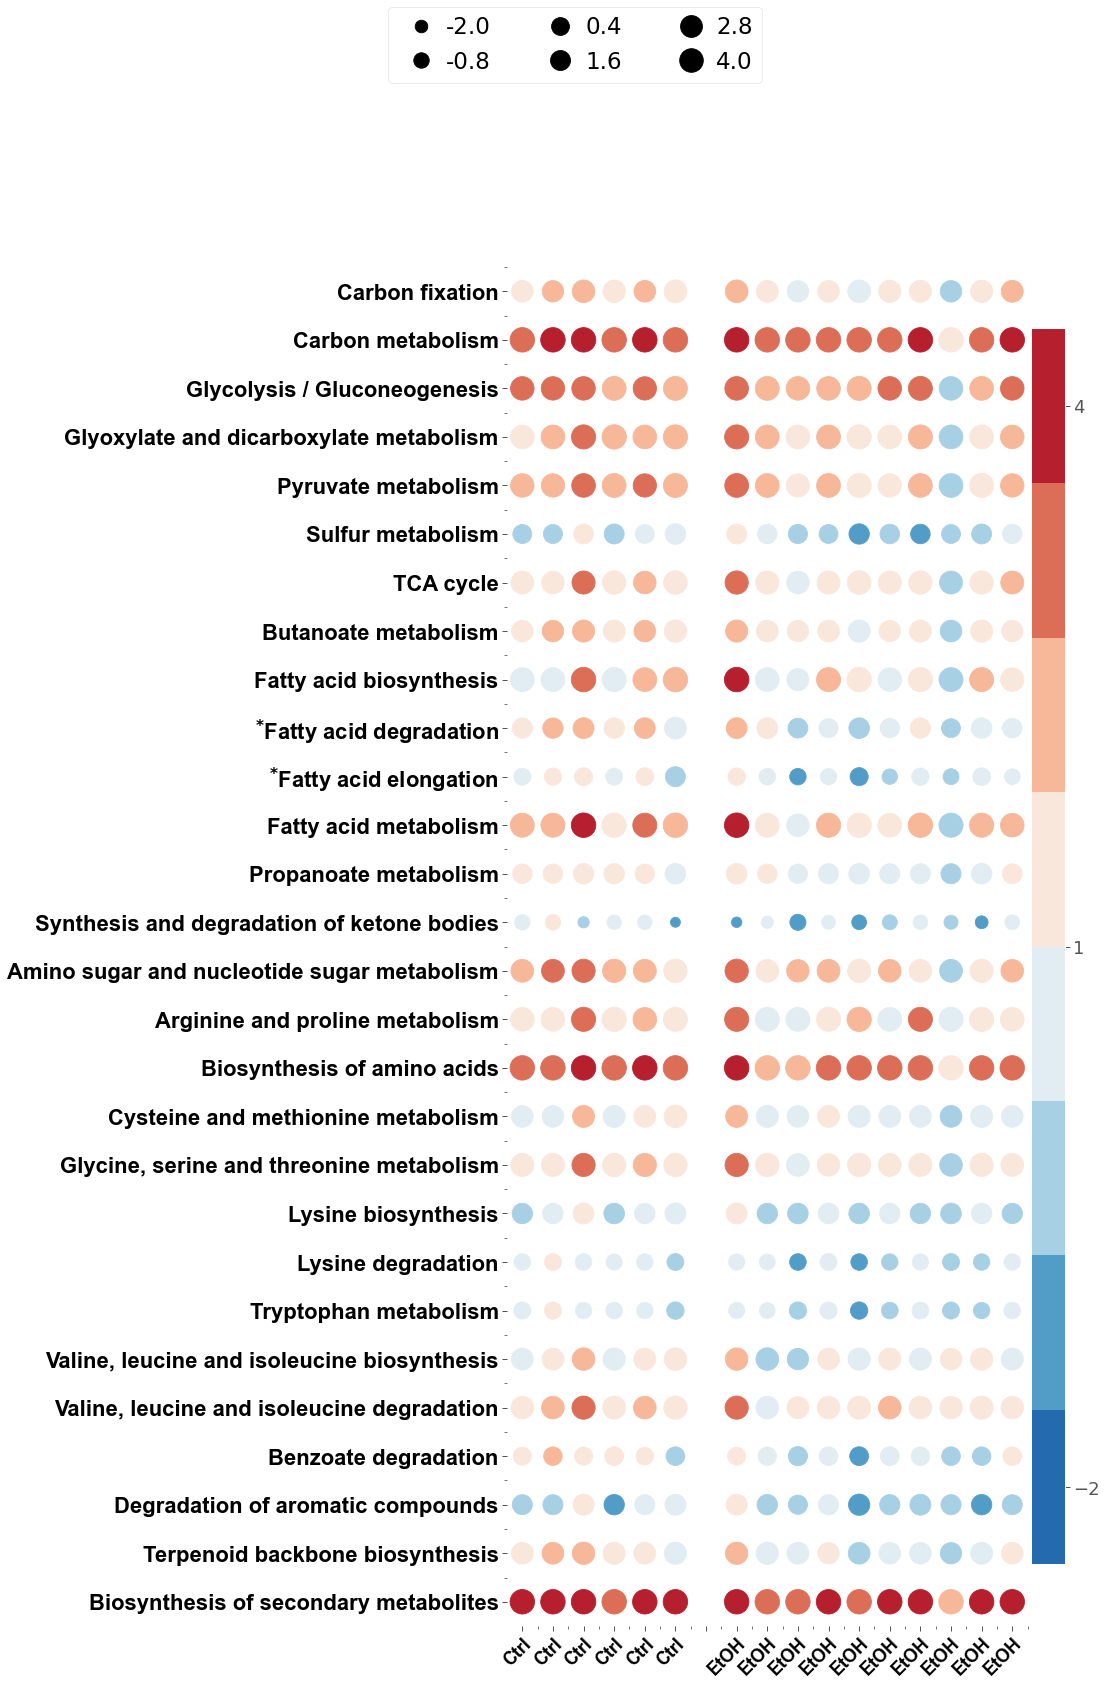

In [1061]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

plt.figure(figsize=(10, 25))

# add fake sample for gap in plot
mf_plot = mf.copy()
mf_plot.loc['680', 'treatment'] = 'Et3OH'
mf_order = mf_plot.reindex(list(shared_samp) + ['680']).sort_values('treatment')

ax = heatmap(y=binned_heatmap_plot['Pathway'],
             x=binned_heatmap_plot['Sample'],
            color=binned_heatmap_plot['Expression'],
            size=binned_heatmap_plot['Abundance'],
            size_scale=600,
            size_range=(-2, 4),
            color_range=(-2, 4),
            marker='o',
            palette=sns.color_palette("RdBu_r", 8),
            x_order=mf_order.index,
            y_order=pathway_with_compound[::-1])

ax.set_xticklabels(['' if 'Et3OH' == x else x 
                    for x in list(mf_order['treatment'].values)], ha='right')
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(18)

# make plotting map for text style
dir_map = binned_heatmap_plot.groupby('Pathway').agg({'compound_direction':'first'})['compound_direction'].to_dict()
bold_map = {'bi-directional':'normal','produced':'bold','consumed':'normal'} # consumed is bold
italic_map = {'bi-directional':'italic','produced':'normal','consumed':'normal'} # bi-dir is italic
bold_map = {k:bold_map[v] for k, v in dir_map.items()}
italic_map = {k:italic_map[v] for k, v in dir_map.items()}
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    #tick.set_weight(bold_map[tick.get_text()])
    #tick.set_style(italic_map[tick.get_text()])
    tick.set_color("black")
    tick.set_fontsize(22)
    
# test pathway sig.
t_res_plot = t_res.reset_index()
t_res_plot = t_res_plot[t_res_plot.level_1 == 'Expression']
significant_pathways = list(t_res_plot[(t_res_plot['P-corrected'] < 0.05)].level_0)
ax.set_yticklabels(['$\\mathbf{^{*}}$' + tick.get_text() if tick.get_text() in significant_pathways
                    else tick.get_text() 
                    for tick in ax.get_yticklabels()])

    
# save the figure to file
plt.savefig('results/figures/pathway-summary.pdf',dpi=600, 
            bbox_inches='tight',
            edgecolor='none')

plt.show()